# В датасете содержится около 73 тысяч записей о взаимодействии пользователей с более чем тремя тысячами публичных статей, размещённых на платформе

In [54]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
# sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

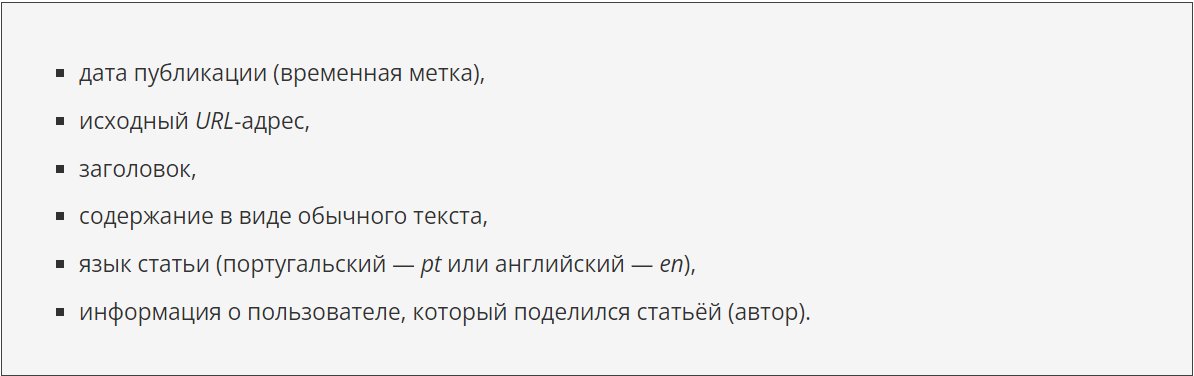

In [56]:
articles_df = pd.read_csv('data/shared_articles.zip')
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        3122 non-null   int64 
 1   eventType        3122 non-null   object
 2   contentId        3122 non-null   int64 
 3   authorPersonId   3122 non-null   int64 
 4   authorSessionId  3122 non-null   int64 
 5   authorUserAgent  680 non-null    object
 6   authorRegion     680 non-null    object
 7   authorCountry    680 non-null    object
 8   contentType      3122 non-null   object
 9   url              3122 non-null   object
 10  title            3122 non-null   object
 11  text             3122 non-null   object
 12  lang             3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


Для временной метки существует два возможных типа событий:
* CONTENT SHARED — статья была опубликована на платформе и доступна для пользователей;
* CONTENT REMOVED — статья была удалена с платформы и недоступна для дальнейших рекомендаций.

Для простоты мы рассматриваем здесь только тип события CONTENT SHARED.

### Задание 6.1
Отфильтруйте данные так, чтобы остались только объекты с типом события CONTENT SHARED. 

Сколько таких объектов в получившейся таблице? 

In [57]:
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']

print(f"Total objects: {articles_df.shape[0]}")

Total objects: 3047


In [58]:
interactions_df = pd.read_csv('data/users_interactions.zip')
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    72312 non-null  int64 
 1   eventType    72312 non-null  object
 2   contentId    72312 non-null  int64 
 3   personId     72312 non-null  int64 
 4   sessionId    72312 non-null  int64 
 5   userAgent    56918 non-null  object
 6   userRegion   56907 non-null  object
 7   userCountry  56918 non-null  object
dtypes: int64(4), object(4)
memory usage: 4.4+ MB


Давайте предварительно преобразуем столбцы personId, contentId в таблицах к строкам. Это преобразование пригодится нам в дальнейшем:

In [59]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

В первую очередь нам необходимо понять, как определить, что какая-то статья популярнее других. Если бы из возможных реакций у нас были только лайки или только просмотры, то статьи было бы легко ранжировать в соответствии с этими значениями. Однако у нас есть информация о различных действиях пользователя, и на её основе мы должны создать некий универсальный индекс популярности.

Составим его из реакций пользователей, придав им разные веса:

In [60]:
event_type = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

### Задание 6.2
Создайте признак, который будет отражать числовой вес для взаимодействия со статьёй (в соответствии с приведёнными выше весами). Вычислите среднее значение для полученного признака. Округлите его до двух знаков после точки-разделителя.

In [61]:
interactions_df['eventWeight'] = interactions_df['eventType'].map(event_type)

print(f"Mean eventWeight: {interactions_df['eventWeight'].mean():.2f}")

Mean eventWeight: 1.24


### Задание 6.3

Чтобы получить хоть какую-то информацию, на которую можно будет опираться, оставьте только тех пользователей, которые взаимодействовали хотя бы с пятью статьями. Сколько всего таких пользователей?

In [62]:
person_df = interactions_df.groupby(by='personId').agg({'contentId': 'nunique'})
person_df.columns = ['Article_count']
person_df = person_df[person_df['Article_count'] >= 5]

print(f"Users : {person_df.shape[0]}")

Users : 1140


In [63]:
person_df

,Article_count
personId,
-1007001694607905623,6
-1032019229384696495,648
-108842214936804958,270
-1119397949556155765,6
-1130272294246983140,112
...,...
953707509720613429,18
983095443598229476,16
989049974880576288,19


### Задание 6.4
Теперь оставим только те взаимодействия, которые касаются только отфильтрованных пользователей (то есть тех, которые взаимодействовали как минимум с пятью статьями). Сколько всего таких взаимодействий?

In [64]:
personId_set = set(person_df.index)
interactions_df = interactions_df[interactions_df['personId'].isin(personId_set)]

print(f"Total intractions with 5 and more articles: {interactions_df.shape[0]}")

Total intractions with 5 and more articles: 69868


### Задание 6.5

Так как каждому возможному действию мы ранее уже присвоили вес, то, по сути, нам нужно просто сложить все действия. Однако полученное число будет увеличиваться с количеством действий, и будет очень большой разброс возможных значений. В таких случаях обычно логарифмируют полученный результат.

Примените упомянутое выше преобразование для логарифмирования к сумме весов для взаимодействия пользователя с каждой конкретной статьёй. Также сохраните для каждой пары «пользователь — статья» значение времени последнего взаимодействия.

Найдите среднее по признаку с получившимися временными отсечками. Округлите результат до двух знаков после точки-разделителя.

In [65]:
person_content_df = interactions_df.groupby(by=['personId', 
                                                'contentId']).agg({'eventWeight': 'sum', 
                                                                   'timestamp': 'max'}).reset_index()
person_content_df.rename(columns={'eventWeight': 'user_preference'}, inplace=True)
person_content_df['user_preference'] = np.log2(person_content_df['user_preference'] + 1)

print(f"Mean timestamp: {person_content_df['timestamp'].mean():.2f}")

Mean timestamp: 1470605340.04


In [66]:
person_content_df

,personId,contentId,user_preference,timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994342
...,...,...,...,...
39101,998688566268269815,-401664538366009049,1.000000,1474567449
39102,998688566268269815,3456674717452933449,2.584963,1478802088
39103,998688566268269815,6881796783400625893,1.000000,1474567675
39104,998688566268269815,7174452660053929140,2.321928,1478812905


### Задание 6.6

Разумеется, для того чтобы впоследствии оценить качество построенной рекомендательной системы, нам нужно разделить выборку на обучающую и тестовую. Так как в реальности рекомендации строятся на основе исторических данных о пользователе и контенте, сделаем в нашей задаче разбиение на обучающую и тестовую выборки по временной отсечке.

Разделите данные на обучающую и тестовую выборки, выбрав в качестве временной отсечки значение 1475519545. Значение отсечки включите в тестовую выборку. Сколько объектов попало в обучающую выборку?

In [67]:
mask = person_content_df['timestamp'] < 1475519545
train, test = person_content_df[mask], person_content_df[~mask]

print(f"In train set: {train.shape[0]} objects.")

In train set: 29325 objects.


In [68]:
# Group the 'train' DataFrame by 'personId' and aggregate the 'contentId' column into a list for each 'personId'
# This creates a DataFrame with 'personId' as the index and a 'true_train' column containing the lists of 'contentId'
final_df = (
    train.groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()  # Reset the index to make 'personId' a regular column
    .rename(columns={'contentId': 'true_train'})  # Rename the 'contentId' column to 'true_train'
    .set_index('personId')  # Set 'personId' as the index again
)

# Group the 'test' DataFrame by 'personId' and aggregate the 'contentId' column into a list for each 'personId'
# This creates a Series with 'personId' as the index and the lists of 'contentId' as the values
# The Series is then assigned to a new 'true_test' column in 'final_df'
final_df['true_test'] = (
    test.groupby('personId')['contentId'].agg(lambda x: list(x))
)

# Replace any NaN values in the 'true_test' column with empty lists
# This ensures that all values in the 'true_test' column are lists, 
# even if there were no corresponding 'contentId' values in the 'test' DataFrame
final_df['true_test'] = [ [] if x is np.NaN else x for x in final_df['true_test'] ]

final_df.head()

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


### Задание 6.7
Осталось совсем немного — скоро вы получите свою первую систему рекомендаций! Мы будем строить popular-based-модель, а значит, нам необходимо найти самые популярные статьи.

Посчитайте популярность каждой статьи как сумму всех логарифмических «оценок» взаимодействий с ней (используя только обучающую выборку). Выберите ID самой популярной статьи:

In [69]:
popular_train = train.groupby('contentId').agg({'user_preference': 'sum'})
popular_train.rename(columns={'user_preference': 'sumWeight'}, inplace=True)
popular_train.sort_values('sumWeight', ascending=False, inplace=True)

print(f"Most popular article ID: {popular_train.index[0]} on train dataset")

Most popular article ID: -6783772548752091658 on train dataset


In [16]:
def get_top_ten_recommend_list(train_list):
    # Retrieve the indices of popular articles from the training data
    all_popular_article = list(popular_train.index)
    recommend_list = []  # Initialize an empty list to store the top 10 recommended articles
    
    # Iterate through the popular articles
    for art in all_popular_article:
        # If the article is not in the training list, add it to the recommendation list
        if art not in train_list:
            recommend_list.append(art)
        
        # If the recommendation list reaches 10 articles, break the loop
        if len(recommend_list) == 10:
            break
        
    # Return the top 10 recommended articles
    return recommend_list

In [70]:
final_df['pred_test'] = final_df['true_train'].apply(get_top_ten_recommend_list)

In [71]:
def precision(column):
    # Convert the 'true_test' and specified 'column' to sets
    true_test_sets = final_df['true_test'].apply(set)
    column_sets = final_df[column].apply(set)

    # Calculate the intersection length for each pair of sets
    intersection_length = [len(a & b) for a, b in zip(true_test_sets, column_sets)]

    # Calculate the denominator, taking the minimum of the length 
    # of the true values (plus a small constant) and 10.0
    denominator = np.minimum(true_test_sets.apply(len) + 0.001, 10.0)

    # Calculate the precision for each row and take the mean
    return (np.array(intersection_length) / denominator).mean()

In [74]:
print(f"Precision value on test dataset: {precision('pred_test'):.3f}")

Precision value on test dataset: 0.006
